# Machine Learning - Boosting
## Masaccio Braun

In the past, we have used machine learning methods that implement a single *learner* i.e. linear regressor, decision tree regressor, etc., as well as learning methods that implement multiple learners i.e. random forest regressor.  Random forest models are known as 'ensemble' methods because they use a group of learners to enhance the performance of each individual learner and create a stronger, aggregate model.  However, many of the individual learners in the ensemble tend to be *weak learners*, such that some tend to make poor predictions based on the observations they are specifically trained on.  One way to combat this is through **boosting**.  Boosting is a derivative of bagging, in which weak learners are trained simultaneously through a random selection, each having equal *weight* in predictive capability.  Boosting differs in that the models have differing weights, since they are trained sequentially to compensate for weak learners by taking the efficacy of the previous model and increasing the weights of the data that the previous model had the highest error with. 

![boostingvsbagging](https://user-images.githubusercontent.com/85206050/155819678-98998612-ea0b-4460-b4fa-794efbc8d292.png)

Source: https://towardsdatascience.com/what-is-boosting-in-machine-learning-2244aa196682 

There are a multitude of methods that can be implemented to boost a model.  In this exploration, I will test a random forest booster and a decision tree booster for locally weighted regression and a version of extreme gradient boosting regression, and compare the results of their predictions in two multivariate analyses.

In [37]:
# Update statsmodels
! pip install statsmodels==0.13.2

In [1]:
# Imports

# General libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Linear algebra
from scipy.linalg import lstsq
from scipy.sparse.linalg import lsmr

# Interpolators
from scipy.interpolate import interp1d, griddata, LinearNDInterpolator, NearestNDInterpolator

# Scalers
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import KFold

# Model Evaluation
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

# Regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg
from xgboost import XGBRegressor

# Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# High-resolution images
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 120

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Tricubic Kernel
def Tricubic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

# Quartic Kernel
def Quartic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,15/16*(1-d**2)**2)

# Epanechnikov Kernel
def Epanechnikov(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,3/4*(1-d**2)) 

### Boston Housing Prices

The first dataset I will try to model will be the Boston Housing Prices dataset, which can be found here: https://www.kaggle.com/prasadperera/the-boston-housing-dataset 

In [5]:
# Load data
houses = pd.read_csv('drive/MyDrive/Data/Boston Housing Prices.csv')
houses.head()

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001


For the multivariate analysis, I will choose 3 feature variables to predict the median value of owner occupied homes: average number of rooms per dwelling, per capita crime rate by town, and full-value property tax rate.  To get an idea of the immediate linear correlation coefficients of the feature and response variables, I will create a heatmap.

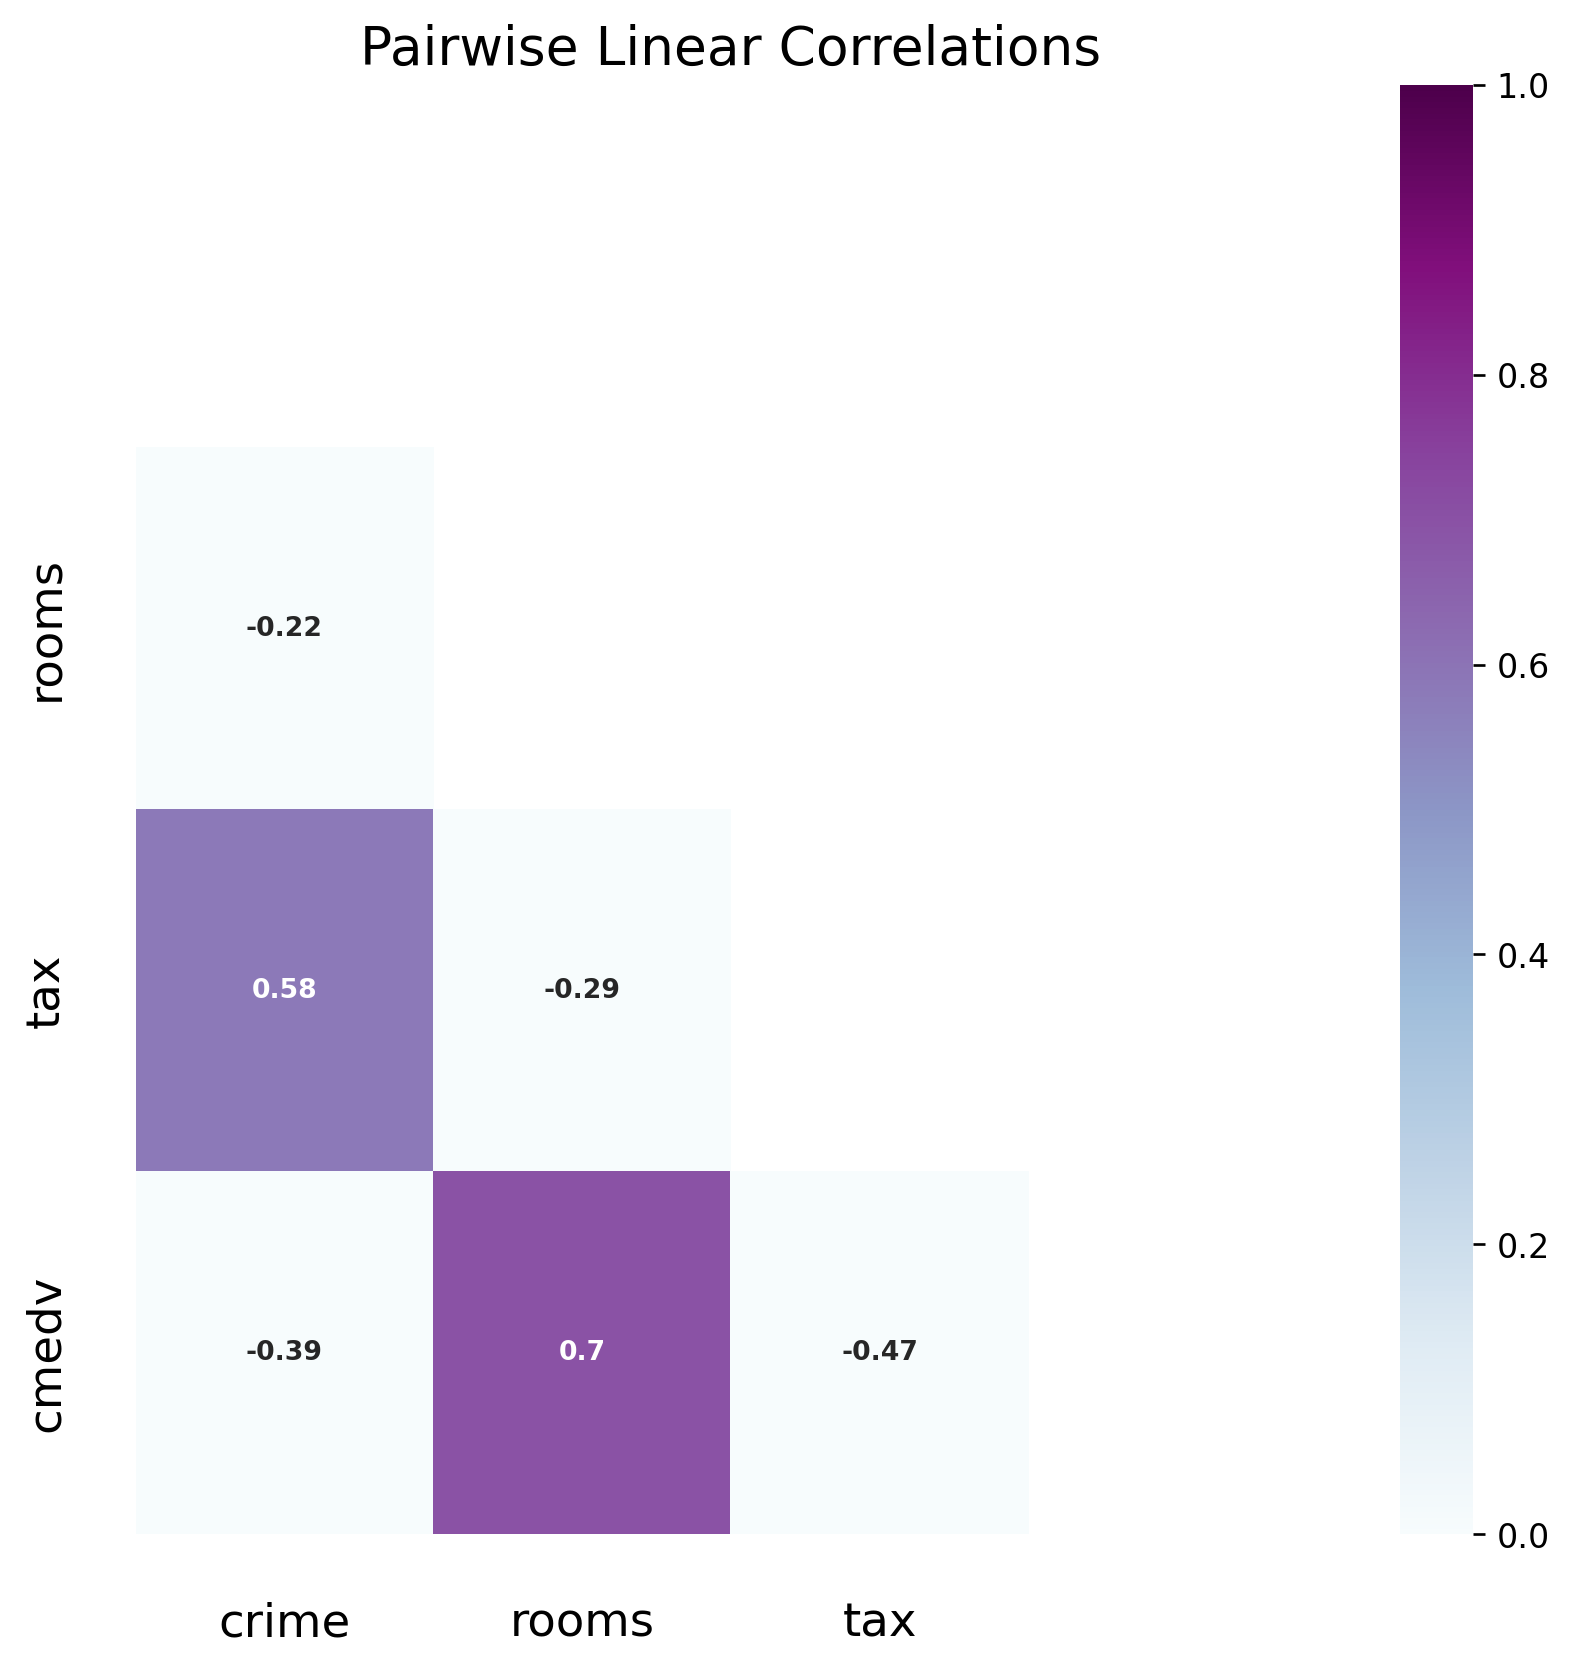

In [57]:
# Select variables and plot data
x = houses[['rooms', 'crime', 'tax']].values
y = houses['cmedv'].values

# Correlation Heatmap
irrel_col = ['town','tract','longitude','latitude','residential','industrial','river','nox','distance','older','highway','ptratio','lstat']
houses_select = houses.drop(columns=irrel_col)
c = houses_select.corr()
mask = np.triu(c)

plt.figure(figsize=(8,8))
sns.heatmap(c, mask=mask, annot=True, annot_kws={'fontsize':8,'weight':'bold'}, cmap='BuPu', vmin=0, vmax=1,
            yticklabels=[' '] + list(houses_select.columns[1:]), xticklabels=houses_select.columns[:-1])
plt.tick_params(size=0, labelsize=14, pad=20)
plt.title('Pairwise Linear Correlations', fontsize=16)
plt.savefig('houses_heat.png')
plt.show()

The only feature that seems to hold any significant linear correlation to median house price is the number of rooms.  Just to get an idea of the distribution of the variables, I will create a pairplot of the relevant data fields.

<Figure size 960x960 with 0 Axes>

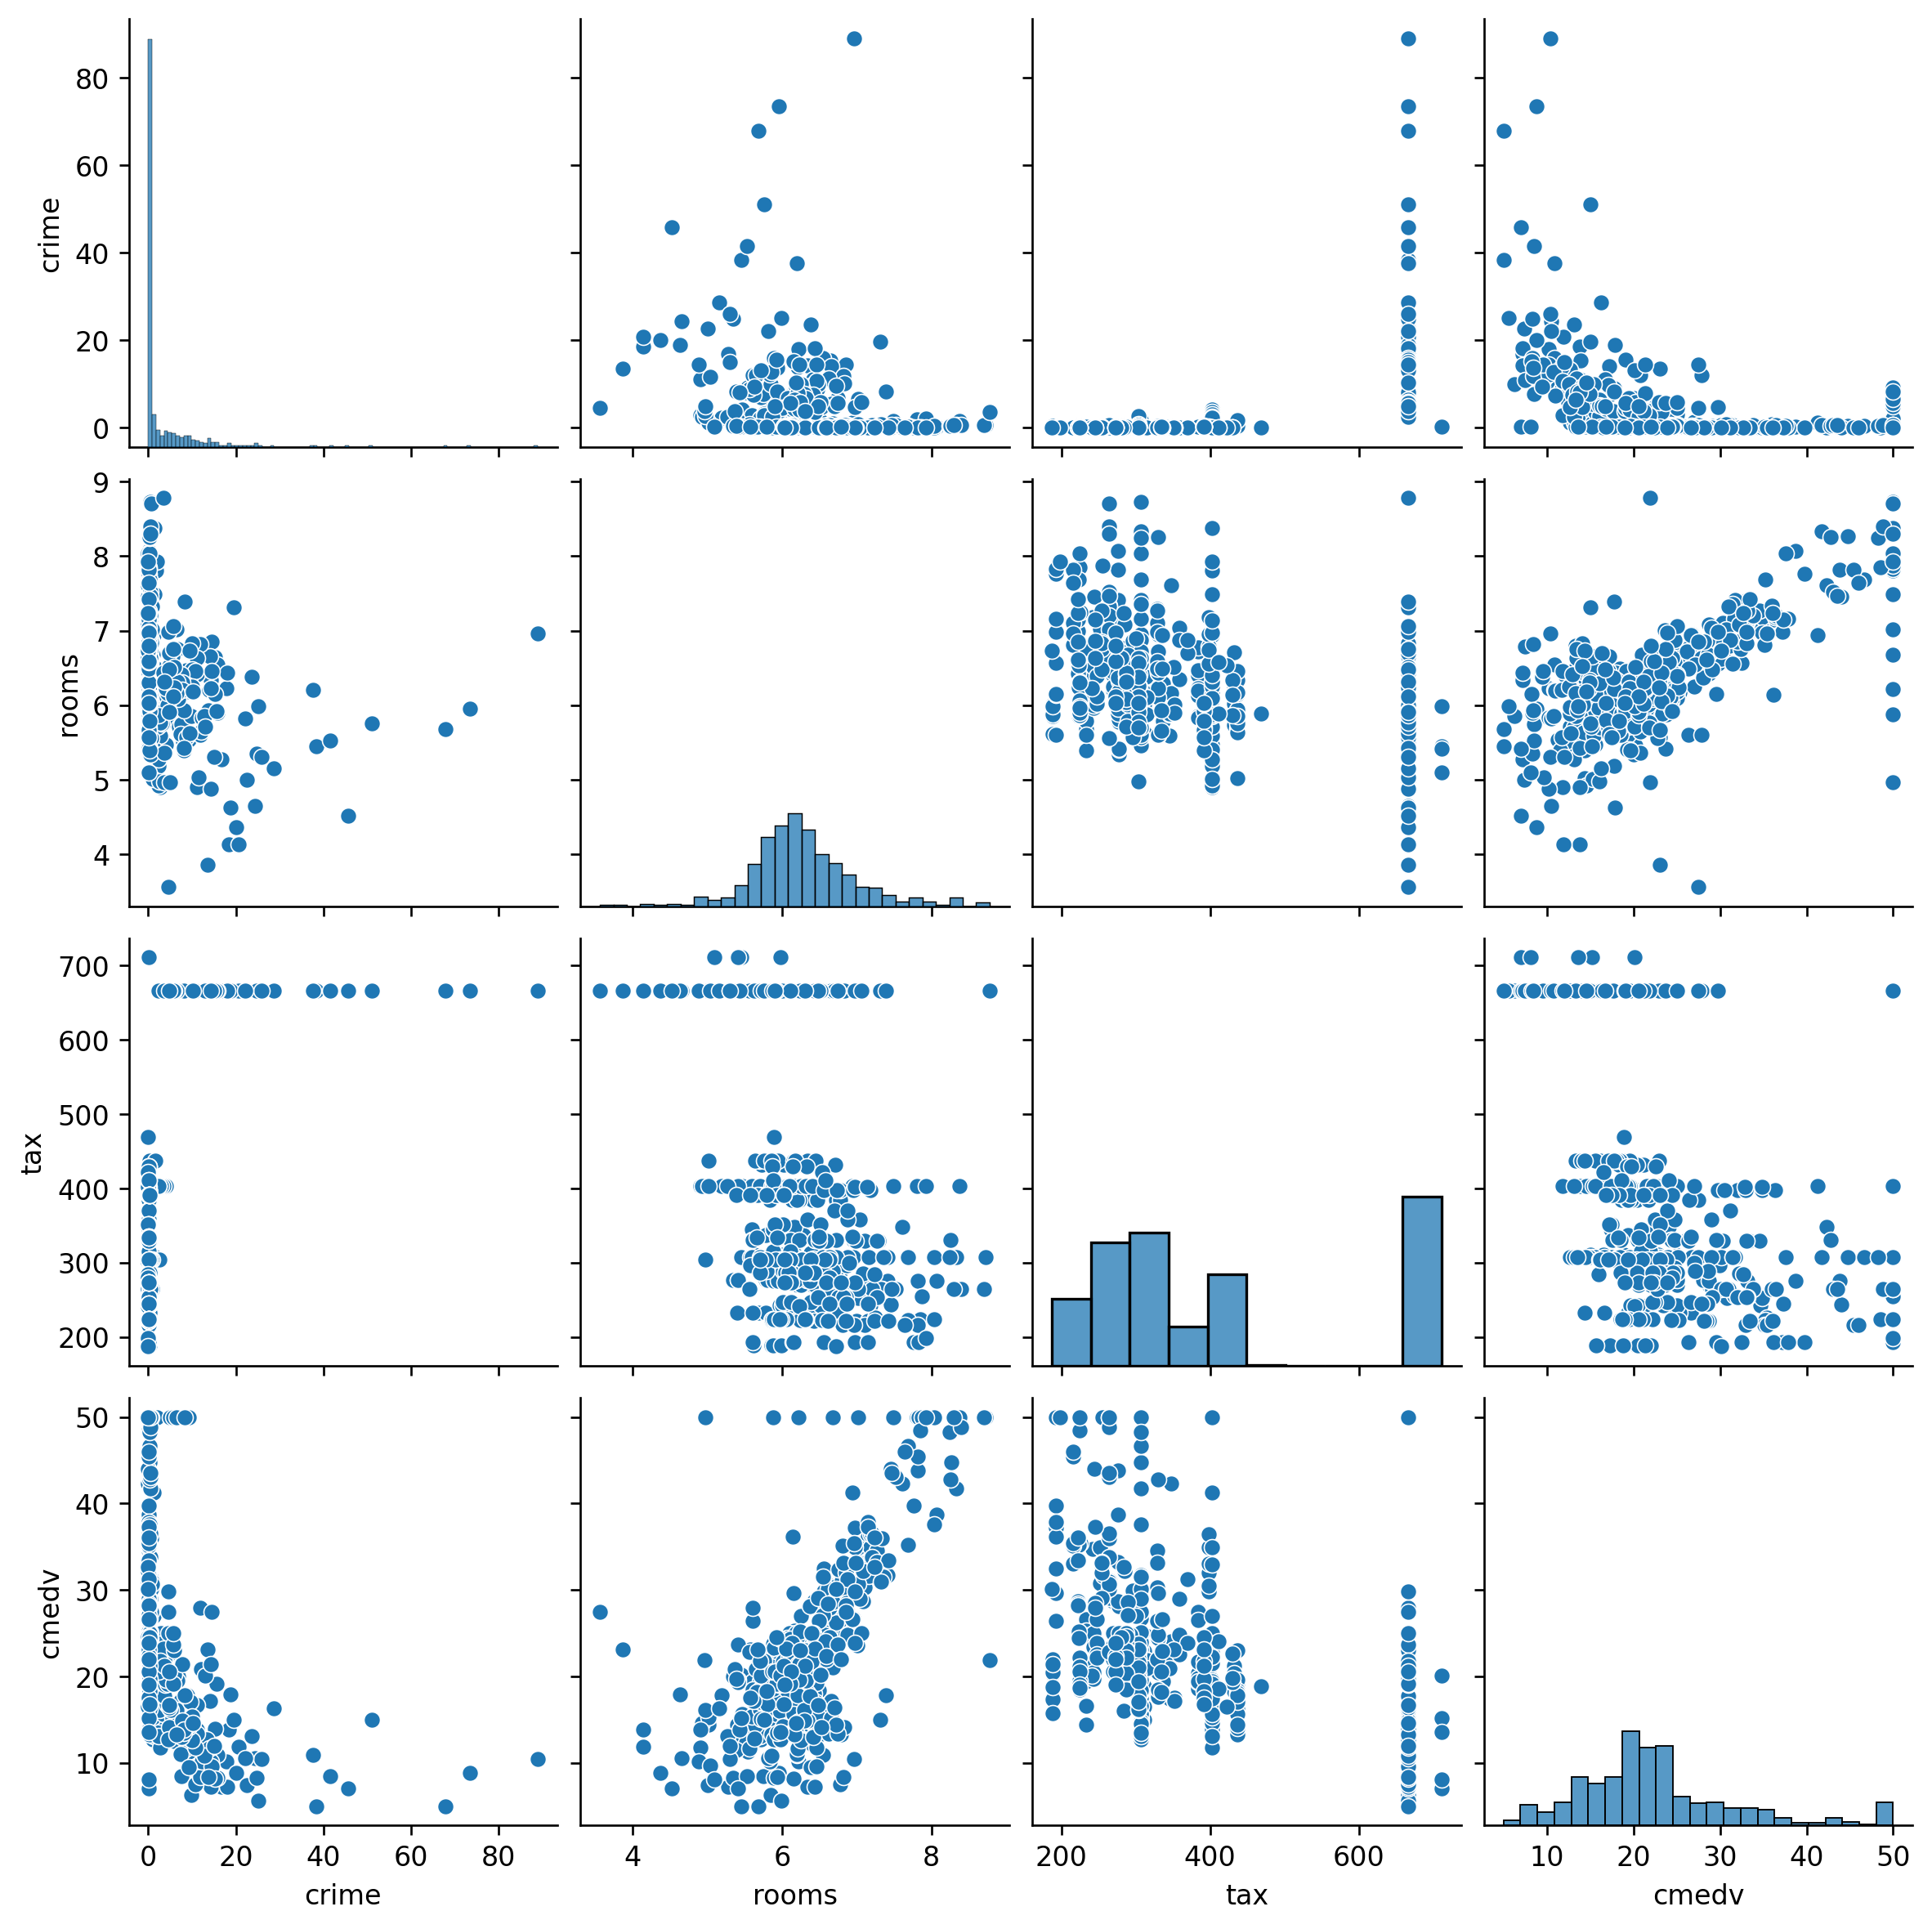

In [7]:
plt.figure(figsize=(8,8))
sns.pairplot(houses_select)
plt.savefig('houses_pair.png')
plt.show()

In [8]:
# Standardization
ss = StandardScaler()

In [9]:
# Cross Validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=410)

To compare against the boosted models, I will be testing an ordinary least-squares linear regression, a decision tree regression, and a random forest regression, as well as an artificial neural network, though I suspect this will perform the poorly.

In [10]:
# Least Squares Regression
lsr = LinearRegression()

In [11]:
# Decision Tree Regression
dtr = DecisionTreeRegressor(max_depth=2, random_state=410)

In [12]:
# Random Forest Regression
rfr = RandomForestRegressor(n_estimators=50, max_depth=2)

In [16]:
# Neural Network
seq = Sequential()

seq.add(Dense(32, activation="relu"))
seq.add(Dense(64, activation="relu"))
seq.add(Dense(128, activation="relu"))
seq.add(Dense(1, activation="linear"))

seq.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-2))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=800)

In [14]:
# Locally Weighted Regression
def lwr(X, y, xnew, kern, tau, intercept, boost=None):
    n = len(X) 
    yest = np.zeros(n)

    if len(y.shape)==1: 
      y = y.reshape(-1,1)

    if len(X.shape)==1:
      X = X.reshape(-1,1)
    
    if intercept:
      X1 = np.column_stack([np.ones((len(X),1)),X])
    else:
      X1 = X

    w = np.array([kern((X - X[i])/(2*tau)) for i in range(n)])

    for i in range(n):          
        W = np.diag(w[:,i])
        b = np.transpose(X1).dot(W).dot(y)
        A = np.transpose(X1).dot(W).dot(X1)
        beta, res, rnk, s = lstsq(A, b)
        yest[i] = np.dot(X1[i],beta)
    if X.shape[1]==1:
      f = interp1d(X.flatten(),yest,fill_value='extrapolate')
    else:
      f = LinearNDInterpolator(X, yest)
    output = f(xnew) 
    if sum(np.isnan(output))>0:
      g = NearestNDInterpolator(X,y.ravel()) 
      output[np.isnan(output)] = g(xnew[np.isnan(output)])
    return output

## Locally Weighted Regression Boosting



In [15]:
# Boosted Locally Weighted Regression
def blwr(X, y, xnew, kern, tau, intercept, boost):
  Fx = lwr(X,y,X,kern,tau,intercept)
  new_y = y - Fx
  boost.fit(X,new_y)
  output = boost.predict(xnew) + lwr(X,y,xnew,kern,tau,intercept)
  return output 

## Extreme Gradient Boosting

A derivative of gradient boosting.  In this method, a set of parallel decision trees are fitted to the residuals of the previous trees' predictions, so it is an ensemble model similar to random forest.  However, instead of relying on traditional decision trees, XGB uses *XGBoost trees*, which are created by calculating *similarity scores* between the observations of the leaf nodes.  Furthermore, XGB implements regularization to prevent overfitting of the individual decision trees.  With XGB, the process of sequentially creating weak models is done so as a *gradient descent* algorithm using an objective cost function, in which the algorithm iterates until the cost function is at close to or equal to zero, or at least at the lowest minima.  In order to minimize the loss function,we take its partial derivative with respect to its slope and its intercept, then subtracting this from the slope beta (denoted theta in the case of the equation below).  The partial derivative is scaled by a desired learning rate (hyperparameter) and this process is repeated until a convergence at the minimum.

![xgbcostfunctionderivative](https://user-images.githubusercontent.com/85206050/155819783-c0e46347-41ea-40ab-98c2-793348a098d0.png)


Source: https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb

In [13]:
# Extreme Gradient Regression
xgbr = XGBRegressor(objective='reg:squarederror', n_estimators=100, reg_lambda=20, alpha=1, gamma=10, max_depth=3)

In [22]:
# Model Set 1
  # Linear (lsr), Decision Tree (dtr), Random Forest (rfr), Extreme Gradient (xgr), 
def RunModel1(model, x , y, scaler, split):
  mse_model = []
  mae_model = []
  r2_model = []

  for idxtrain, idxtest in kf.split(x):
    xtrain = x[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = x[idxtest]
    xtrain = ss.fit_transform(xtrain)
    xtest = ss.transform(xtest)

    model.fit(xtrain, ytrain)
    yhat = model.predict(xtest)

    mse_model.append(mse(ytest, yhat))
    mae_model.append(mae(ytest, yhat))
    r2_model.append(r2(ytest, yhat))

  return np.mean(mse_model), np.mean(mae_model), np.mean(r2_model)

In [23]:
# Model Set 2
  # Loess, Boosted Loess
def RunModel2(model, x , y, kern, tau, scaler, split, boost=None):
  mse_model = []
  mae_model = []
  r2_model = []

  for idxtrain, idxtest in kf.split(x):
    xtrain = x[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = x[idxtest]
    xtrain = ss.fit_transform(xtrain)
    xtest = ss.transform(xtest)

    yhat = model(xtrain,ytrain, xtest, kern, tau=tau, intercept=True, boost=boost)

    mse_model.append(mse(ytest, yhat))
    mae_model.append(mae(ytest, yhat))
    r2_model.append(r2(ytest, yhat))

  return np.mean(mse_model), np.mean(mae_model), np.mean(r2_model)

In [24]:
# Model Set 3
  # Neural Network
def RunNN(model, x , y, scaler, split, val_split=0.25, epoch=500, batch=20):
  mse_model = []
  mae_model = []
  r2_model = []

  for idxtrain, idxtest in kf.split(x):
    xtrain = x[idxtrain]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    xtest = x[idxtest]
    xtrain = ss.fit_transform(xtrain)
    xtest = ss.transform(xtest)

    model.fit(xtrain, ytrain, validation_split=val_split, epochs=epoch, batch_size=batch, verbose=0, callbacks=[es])
    yhat = seq.predict(xtest)

    mse_model.append(mse(ytest, yhat))
    mae_model.append(mae(ytest, yhat))
    r2_model.append(r2(ytest, yhat))

  return np.mean(mse_model), np.mean(mae_model), np.mean(r2_model)

In [26]:
mse_lsr, mae_lsr, r2_lsr = RunModel1(lsr, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Least-Squares Regression is : ' + str(mse_lsr))
print('The Cross-validated Mean Absolute Error for Least-Squares Regression is : ' + str(mae_lsr))
print('The Cross-validated Coefficient of Determination for Least-Squares Regression is : ' + str(r2_lsr))

The Cross-validated Mean Squared Error for Least-Squares Regression is : 37.23940104890824
The Cross-validated Mean Absolute Error for Least-Squares Regression is : 4.020970004960848
The Cross-validated Coefficient of Determination for Least-Squares Regression is : 0.5478240461818417


In [27]:
mse_dtr, mae_dtr, r2_dtr = RunModel1(dtr, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Decision Tree Regression is : ' + str(mse_dtr))
print('The Cross-validated Mean Absolute Error for Decision Tree Regression is : ' + str(mae_dtr))
print('The Cross-validated Coefficient of Determination for Decision Tree Regression is : ' + str(r2_dtr))

The Cross-validated Mean Squared Error for Decision Tree Regression is : 35.18217909437036
The Cross-validated Mean Absolute Error for Decision Tree Regression is : 4.063618925443233
The Cross-validated Coefficient of Determination for Decision Tree Regression is : 0.5680960234893112


In [28]:
mse_rfr, mae_rfr, r2_rfr = RunModel1(rfr, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Random Forest Regression is : ' + str(mse_rfr))
print('The Cross-validated Mean Absolute Error for Random Forest Regression is : ' + str(mae_rfr))
print('The Cross-validated Coefficient of Determination for Random Forest Regression is : ' + str(r2_rfr))

The Cross-validated Mean Squared Error for Random Forest Regression is : 31.9639600875443
The Cross-validated Mean Absolute Error for Random Forest Regression is : 3.8578840078128542
The Cross-validated Coefficient of Determination for Random Forest Regression is : 0.6121888076614384


In [34]:
mse_seq, mae_seq, r2_seq = RunNN(seq, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Neural Network is : ' + str(mse_seq))
print('The Cross-validated Mean Absolute Error for Neural Network is : ' + str(mae_seq))
print('The Cross-validated Coefficient of Determination for Neural Network is : ' + str(r2_seq))

The Cross-validated Mean Squared Error for Neural Network is : 85.57445466742146
The Cross-validated Mean Absolute Error for Neural Network is : 5.030748784209109
The Cross-validated Coefficient of Determination for Neural Network is : -0.1203951433644184


In [31]:
mse_lwr, mae_lwr, r2_lwr = RunModel2(lwr, x, y, Tricubic, 0.9, ss, kf)
print('The Cross-validated Mean Squared Error for Locally Weighted Regression is : ' + str(mse_lwr))
print('The Cross-validated Mean Absolute Error for Locally Weighted Regression is : ' + str(mae_lwr))
print('The Cross-validated Coefficient of Determination for Locally Weighted Regression is : ' + str(r2_lwr))

The Cross-validated Mean Squared Error for Locally Weighted Regression is : 26.597270697712815
The Cross-validated Mean Absolute Error for Locally Weighted Regression is : 3.3010239544041284
The Cross-validated Coefficient of Determination for Locally Weighted Regression is : 0.6845775749624277


In [32]:
mse_blwr, mae_blwr, r2_blwr = RunModel2(blwr, x, y, Quartic, 0.9, ss, kf, dtr)
print('The Cross-validated Mean Squared Error for Locally Weighted Regression Boosted with Decision Trees is : ' + str(mse_blwr))
print('The Cross-validated Mean Absolute Error for Locally Weighted Regression Boosted with Decision Trees is : ' + str(mae_blwr))
print('The Cross-validated Coefficient of Determination for Locally Weighted Regression Boosted with Decision Trees is : ' + str(r2_blwr))

The Cross-validated Mean Squared Error for Locally Weighted Regression Boosted with Decision Trees is : 26.943911216871744
The Cross-validated Mean Absolute Error for Locally Weighted Regression Boosted with Decision Trees is : 3.2946931437035536
The Cross-validated Coefficient of Determination for Locally Weighted Regression Boosted with Decision Trees is : 0.6813133952301352


In [33]:
mse_blwr, mae_blwr, r2_blwr = RunModel2(blwr, x, y, Quartic, 0.9, ss, kf, boost=rfr)
print('The Cross-validated Mean Squared Error for Locally Weighted Regression Boosted with Random Forest is : ' + str(mse_blwr))
print('The Cross-validated Mean Absolute Error for Locally Weighted Regression Boosted with Random Forest is : ' + str(mae_blwr))
print('The Cross-validated Coefficient of Determination for Locally Weighted Regression Boosted with Random Forest is : ' + str(r2_blwr))

The Cross-validated Mean Squared Error for Locally Weighted Regression Boosted with Random Forest is : 26.68176106594833
The Cross-validated Mean Absolute Error for Locally Weighted Regression Boosted with Random Forest is : 3.2491331849574685
The Cross-validated Coefficient of Determination for Locally Weighted Regression Boosted with Random Forest is : 0.6858306843421442


In [30]:
mse_xgbr, mae_xgbr, r2_xgbr = RunModel1(xgbr, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Extreme Gradient Regression is : ' + str(mse_xgbr))
print('The Cross-validated Mean Absolute Error for Extreme Gradient Regression is : ' + str(mae_xgbr))
print('The Cross-validated Coefficient of Determination for Extreme Gradient Regression is : ' + str(r2_xgbr))

The Cross-validated Mean Squared Error for Extreme Gradient Regression is : 26.548227007953603
The Cross-validated Mean Absolute Error for Extreme Gradient Regression is : 3.217740893794725
The Cross-validated Coefficient of Determination for Extreme Gradient Regression is : 0.6886189666427519


Overall, all of the models performed relatively poorly.  Locally weighted regression performed the best out of the standard nonparametric models, performing marginally better than its primary competitor, random forest regression.  On a side note, the ordinary linear regression did not fare so badly against the decision tree regression, which was a suprising result.  The artificial neural network is a useless model and is unable to account for any of the explained variation in the data with a negative R^2 score.  Strangely, the boosted versions of the locally weighted regression, both the decision tree and random forest, performed slightly poorer than the standard model, which is to say the current state that I constructed added no predicitve power.  Unfortunately, the same can be said for the extreme gradient boosting, which performed the best out of all of the models.  Overall, the boosted models did perform marginally better than the standard models; however, I suspect that they are ill-equipped to make solid predictions for this particular data.

### Concrete Data

The second dataset I will try to model will be the Boston Housing Prices dataset, which can be found here: https://www.kaggle.com/elikplim/concrete-compressive-strength-data-set 

In [41]:
# Load Data
concrete = pd.read_csv('drive/MyDrive/Data/concrete.csv')
concrete.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Like before, I will choose 3 feature variables to predict the compressive strength of the concrete: the amount of the cement component, the amount of the slag component, and the amount of the water component.  To get an idea of the immediate linear correlation coefficients and distributions of the feature and response variables, I will again create a heatmap and a pairplot.

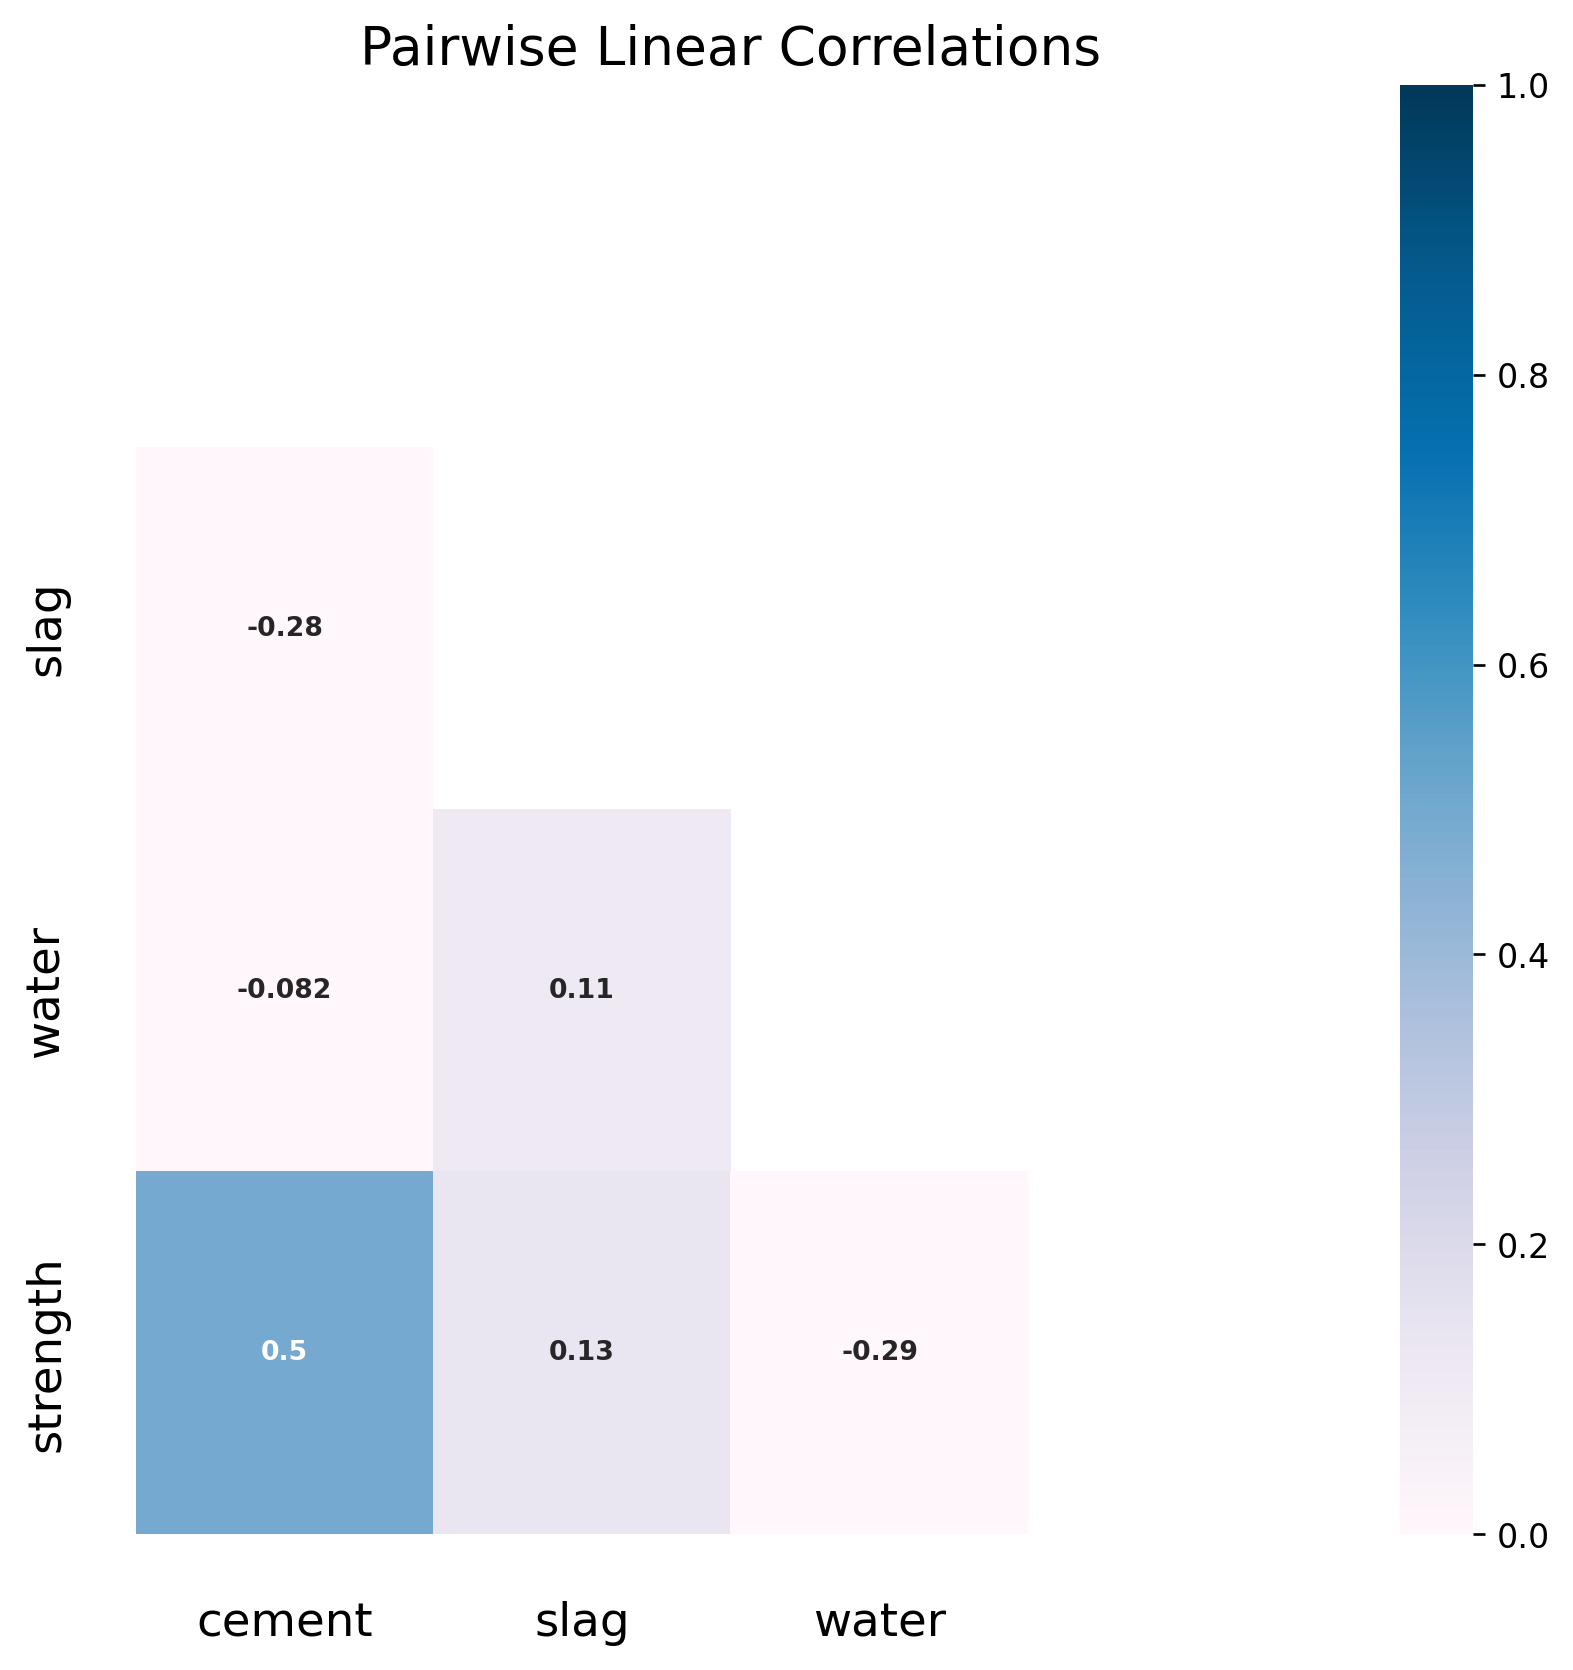

In [56]:
# Select variables and plot data
x = concrete[['cement','slag','water']].values
y = concrete['strength'].values

# Correlation Heatmap
irrel_col = ['ash','superplastic','coarseagg','fineagg','age']
concrete_select = concrete.drop(columns=irrel_col)
c = concrete_select.corr()
mask = np.triu(c)

plt.figure(figsize=(8,8))
sns.heatmap(c, mask=mask, annot=True, annot_kws={'fontsize':8,'weight':'bold'}, cmap='PuBu', vmin=0, vmax=1,
            yticklabels=[' '] + list(concrete_select.columns[1:]), xticklabels=concrete_select.columns[:-1])
plt.tick_params(size=0, labelsize=14, pad=20)
plt.title('Pairwise Linear Correlations', fontsize=16)
plt.savefig('concrete_heat.png')
plt.show()

<Figure size 960x960 with 0 Axes>

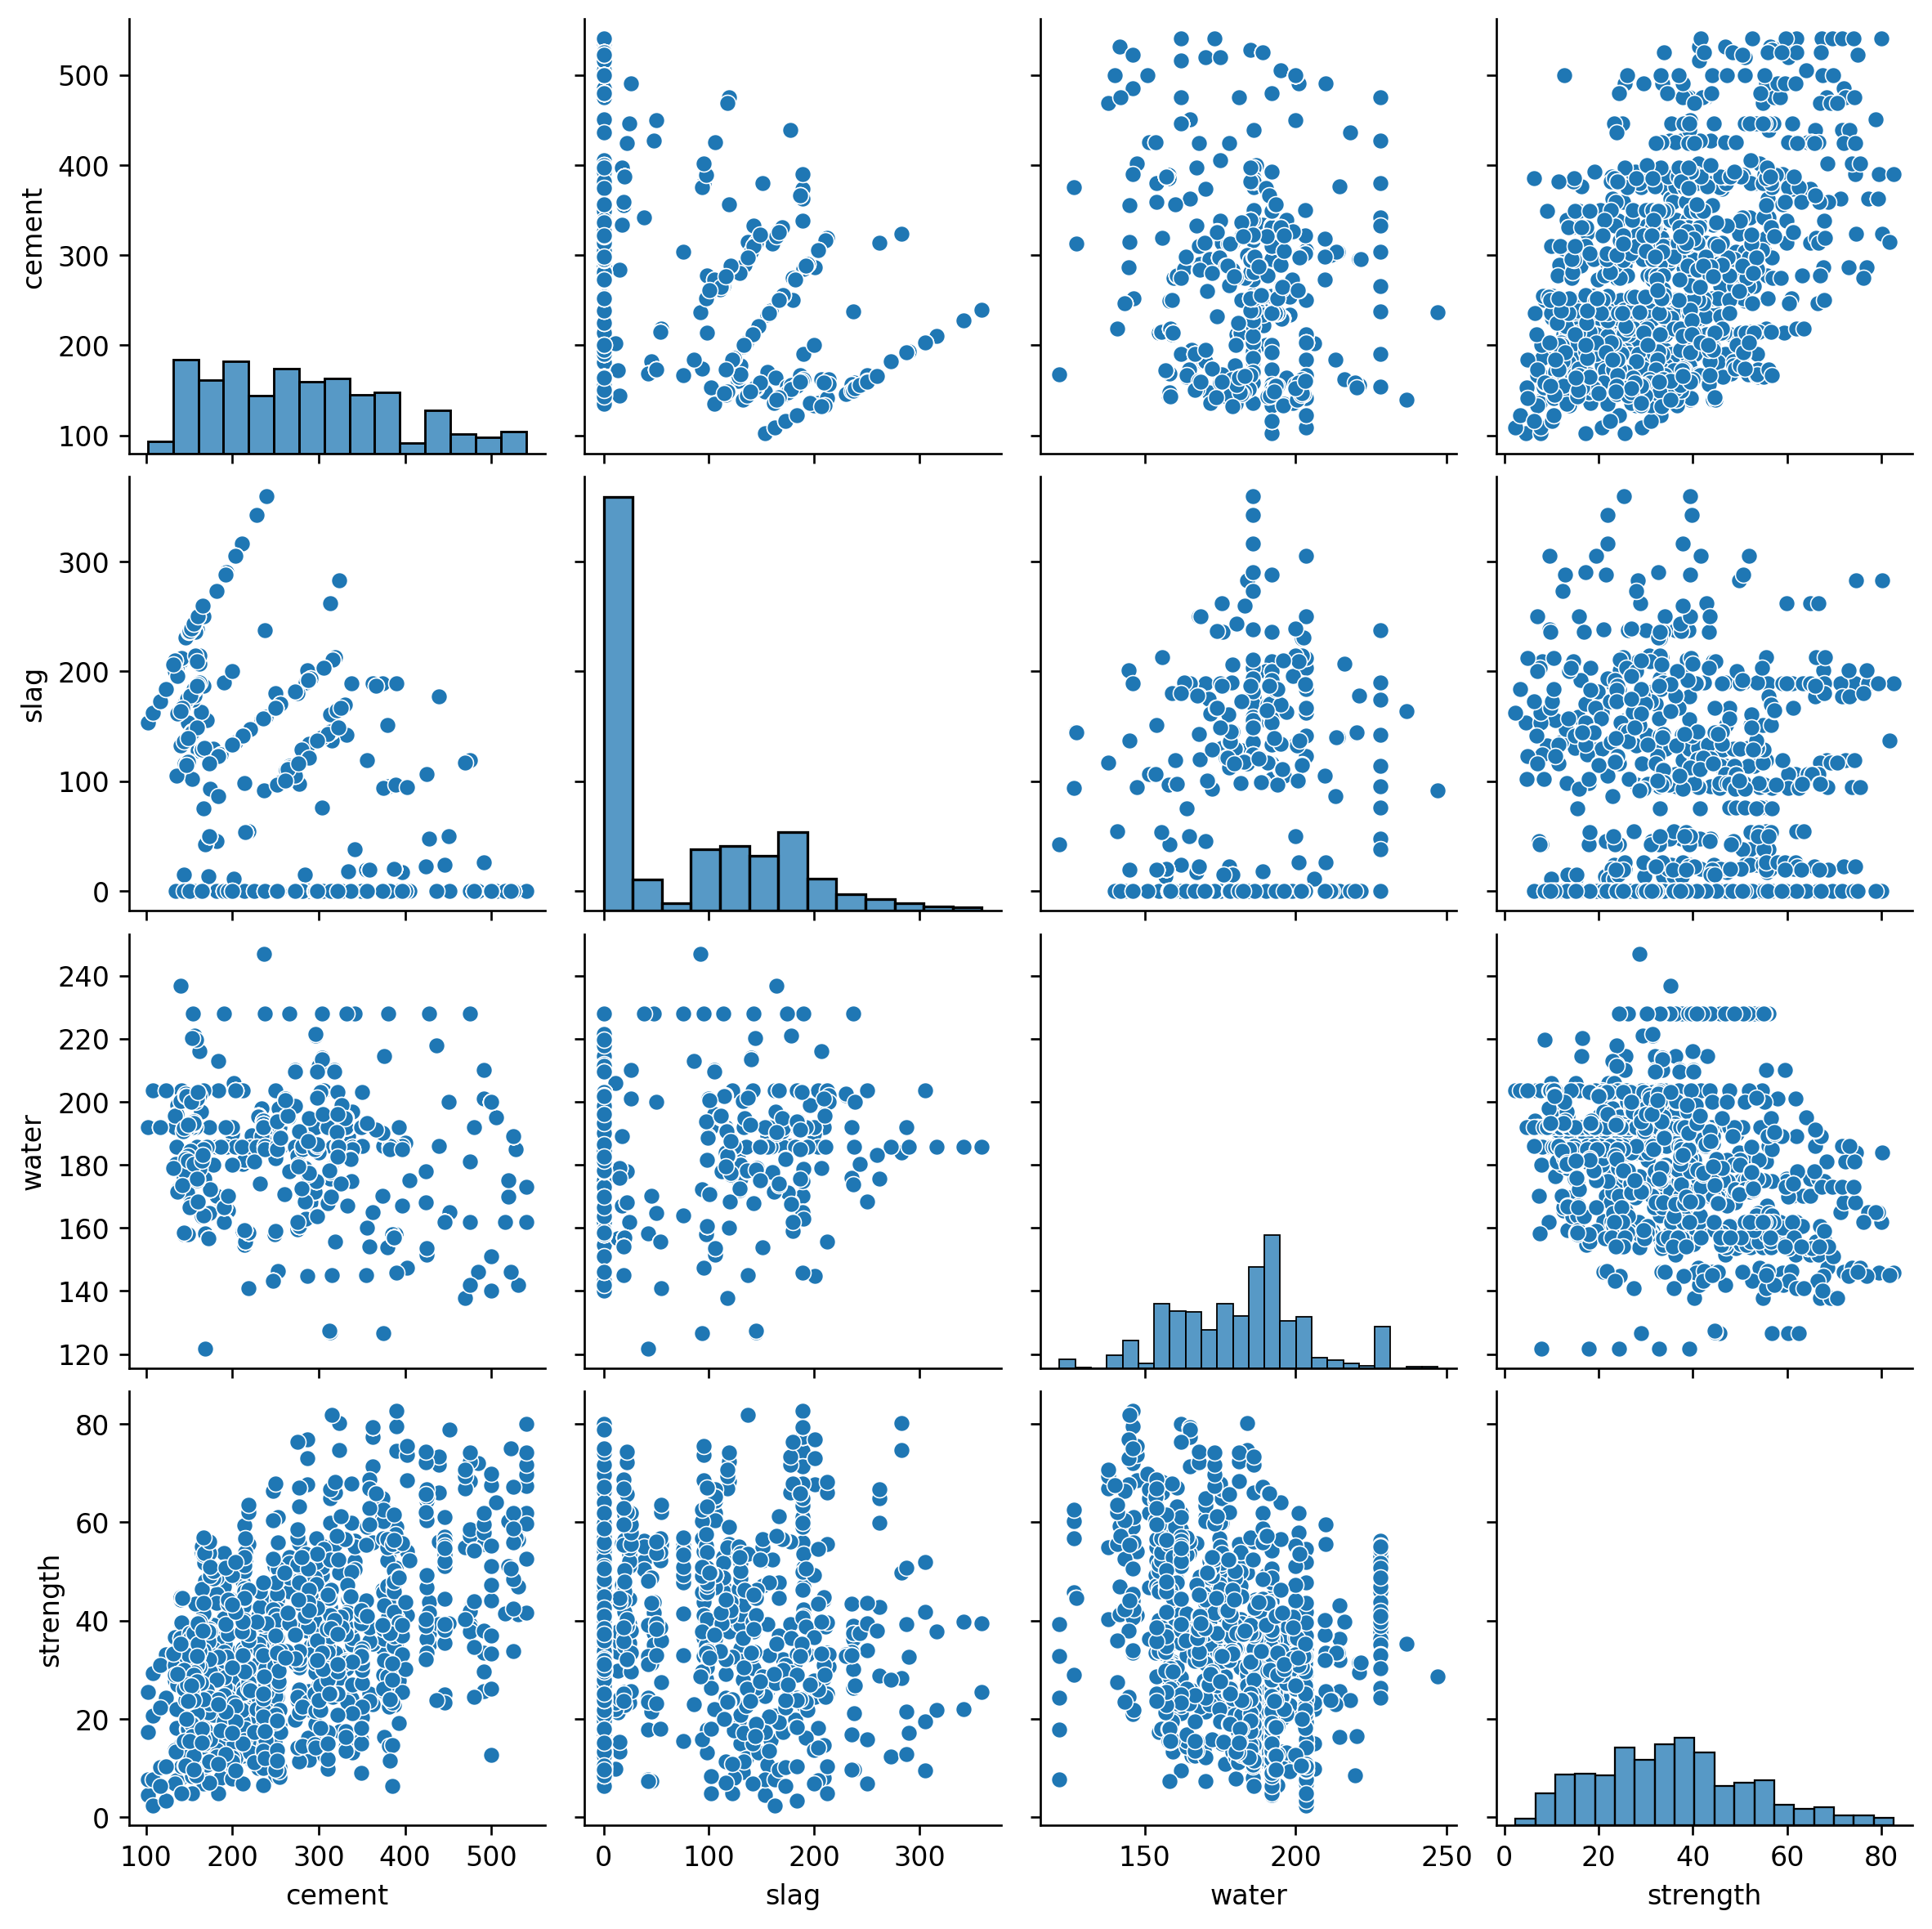

In [47]:
plt.figure(figsize=(8,8))
sns.pairplot(concrete_select)
plt.savefig('concrete_pair.png')
plt.show()

In [48]:
mse_lsr, mae_lsr, r2_lsr = RunModel1(lsr, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Least-Squares Regression is : ' + str(mse_lsr))
print('The Cross-validated Mean Absolute Error for Least-Squares Regression is : ' + str(mae_lsr))
print('The Cross-validated Coefficient of Determination for Least-Squares Regression is : ' + str(r2_lsr))

The Cross-validated Mean Squared Error for Least-Squares Regression is : 167.78526376603222
The Cross-validated Mean Absolute Error for Least-Squares Regression is : 10.429406509600094
The Cross-validated Coefficient of Determination for Least-Squares Regression is : 0.38806908236831456


In [49]:
mse_dtr, mae_dtr, r2_dtr = RunModel1(dtr, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Decision Tree Regression is : ' + str(mse_dtr))
print('The Cross-validated Mean Absolute Error for Decision Tree Regression is : ' + str(mae_dtr))
print('The Cross-validated Coefficient of Determination for Decision Tree Regression is : ' + str(r2_dtr))

The Cross-validated Mean Squared Error for Decision Tree Regression is : 196.55510778069464
The Cross-validated Mean Absolute Error for Decision Tree Regression is : 11.42242710516928
The Cross-validated Coefficient of Determination for Decision Tree Regression is : 0.283131231488064


In [50]:
mse_rfr, mae_rfr, r2_rfr = RunModel1(rfr, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Random Forest Regression is : ' + str(mse_rfr))
print('The Cross-validated Mean Absolute Error for Random Forest Regression is : ' + str(mae_rfr))
print('The Cross-validated Coefficient of Determination for Random Forest Regression is : ' + str(r2_rfr))

The Cross-validated Mean Squared Error for Random Forest Regression is : 185.20401382173023
The Cross-validated Mean Absolute Error for Random Forest Regression is : 11.121562873963494
The Cross-validated Coefficient of Determination for Random Forest Regression is : 0.3260469998620026


In [55]:
mse_seq, mae_seq, r2_seq = RunNN(seq, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Neural Network is : ' + str(mse_seq))
print('The Cross-validated Mean Absolute Error for Neural Network is : ' + str(mae_seq))
print('The Cross-validated Coefficient of Determination for Neural Network is : ' + str(r2_seq))

The Cross-validated Mean Squared Error for Neural Network is : 185.4012886376533
The Cross-validated Mean Absolute Error for Neural Network is : 11.223063258865505
The Cross-validated Coefficient of Determination for Neural Network is : 0.32458313308094616


In [52]:
mse_lwr, mae_lwr, r2_lwr = RunModel2(lwr, x, y, Tricubic, 0.9, ss, kf)
print('The Cross-validated Mean Squared Error for Locally Weighted Regression is : ' + str(mse_lwr))
print('The Cross-validated Mean Absolute Error for Locally Weighted Regression is : ' + str(mae_lwr))
print('The Cross-validated Coefficient of Determination for Locally Weighted Regression is : ' + str(r2_lwr))

The Cross-validated Mean Squared Error for Locally Weighted Regression is : 146.4227649591804
The Cross-validated Mean Absolute Error for Locally Weighted Regression is : 9.768092527277217
The Cross-validated Coefficient of Determination for Locally Weighted Regression is : 0.4654909181670496


In [53]:
mse_blwr, mae_blwr, r2_blwr = RunModel2(blwr, x, y, Quartic, 0.9, ss, kf, dtr)
print('The Cross-validated Mean Squared Error for Locally Weighted Regression Boosted with Decision Trees is : ' + str(mse_blwr))
print('The Cross-validated Mean Absolute Error for Locally Weighted Regression Boosted with Decision Trees is : ' + str(mae_blwr))
print('The Cross-validated Coefficient of Determination for Locally Weighted Regression Boosted with Decision Trees is : ' + str(r2_blwr))

The Cross-validated Mean Squared Error for Locally Weighted Regression Boosted with Decision Trees is : 141.5780947490901
The Cross-validated Mean Absolute Error for Locally Weighted Regression Boosted with Decision Trees is : 9.551662686619025
The Cross-validated Coefficient of Determination for Locally Weighted Regression Boosted with Decision Trees is : 0.4829019098259071


In [54]:
mse_blwr, mae_blwr, r2_blwr = RunModel2(blwr, x, y, Quartic, 0.9, ss, kf, boost=rfr)
print('The Cross-validated Mean Squared Error for Locally Weighted Regression Boosted with Random Forest is : ' + str(mse_blwr))
print('The Cross-validated Mean Absolute Error for Locally Weighted Regression Boosted with Random Forest is : ' + str(mae_blwr))
print('The Cross-validated Coefficient of Determination for Locally Weighted Regression Boosted with Random Forest is : ' + str(r2_blwr))

The Cross-validated Mean Squared Error for Locally Weighted Regression Boosted with Random Forest is : 142.51517506407464
The Cross-validated Mean Absolute Error for Locally Weighted Regression Boosted with Random Forest is : 9.620449887420262
The Cross-validated Coefficient of Determination for Locally Weighted Regression Boosted with Random Forest is : 0.47975481741057535


In [51]:
mse_xgbr, mae_xgbr, r2_xgbr = RunModel1(xgbr, x, y, ss, kf)
print('The Cross-validated Mean Squared Error for Extreme Gradient Regression is : ' + str(mse_xgbr))
print('The Cross-validated Mean Absolute Error for Extreme Gradient Regression is : ' + str(mae_xgbr))
print('The Cross-validated Coefficient of Determination for Extreme Gradient Regression is : ' + str(r2_xgbr))

The Cross-validated Mean Squared Error for Extreme Gradient Regression is : 142.3439960678086
The Cross-validated Mean Absolute Error for Extreme Gradient Regression is : 9.609343509785178
The Cross-validated Coefficient of Determination for Extreme Gradient Regression is : 0.4814444923220341


Like before, all of the models performed relatively poorly, though much more poorly than with the first data.  Again, locally weighted regression performed the best out of the standard nonparametric models. However, even more strangely than with the last data, ordinary linear regression performed marginally better than both the decision tree and random forest regressions, though I suspect with a little optimization, these two could surpass it.  The artificial neural network handled this data much better than the last, and achieved a result that competes with the nonparametric models.  In this case, both of the boosted versions of the locally weighted regression did perform slightly better than the standard model.  The extreme gradient regression again performed the best out of all of the models.  Overall, the boosted models perform marginally better than the standard models again.  I suspect most of the differences in the results between the two data are result of my variable selection.

## Limitations

As previously mentioned, all of the tested models were ill-suited to both data, and the next priority task is to perform adequate variable selection.  Furthermore, it would be beneficial to perform optimization through hyperparameter selection loops, to determine the best construction of each model for each dataset.  Overall, I can conclude that boosting is effective, and for this to become more obvious, I suspect that I need to improve it with repeated boostings.